In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm import tqdm

def collect_data(path, hearts, n_radial, n_angular, node_step):
    collected_data = [[], []]
    
    for heart, _ in hearts.items():
        path_ = path_stats.joinpath(heart, 'Stats')
        files = list(path_.glob('*{}'.format('.pkl')))
        files = sorted([file.stem for file in files if not file.name.startswith('.')])
    
        for slice_name in tqdm(files[:]):
            # Load slice and build HeartSlice object
            heart_slice_builder = HeartSliceBuilder()
            heart_slice_builder.build_from_file(path, heart, slice_name,
                                                n_angular, n_radial, node_step)
            heart_slice = heart_slice_builder.heart_slice
    
            # Load stats
            for i, subdir in enumerate(['Stats', 'StatsGenerated']):
                path_slice_stats = path_stats.joinpath(heart, subdir, slice_name)
                stats_loader = StatsLoader(path_stats)
                object_stats = stats_loader.load_slice_data(path_slice_stats)
        
                # Build objects properties
                objects_props_builder = ObjectsPropertiesBuilder()
                objects_props_builder.build_from_stats(object_stats)
                objects_props_builder.add_slice_props(heart_slice)
                objects_props = objects_props_builder.objects_props
                objects_props = objects_props.loc[:, ['segment_labels',
                                                      'relative_orientation',
                                                      'axis_ratio',
                                                      'area', 'density']]
        
                objects_props['location'] = pd.cut(objects_props['segment_labels'],
                                                   bins=np.linspace(0, n_angular * n_radial,
                                                                    n_radial + 1),
                                                   labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
                objects_props['heart'] = heart
        
                collected_data[i].append(objects_props)
    
    df = pd.concat(collected_data[0], ignore_index=True)
    df_gen = pd.concat(collected_data[1], ignore_index=True)
    return df, df_gen

In [6]:
path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
path_stats = path

hearts = {'E10691_RBM20': 'A', 'E11444_LMNA': 'B', 'E10927_MYBPC3': 'C'}

n_radial = 3
n_angular = 12
node_step = 3


df, df_gen = collect_data(path, hearts, n_radial, n_angular, node_step)

 94%|████████████████████████████████████████████████████████████████████▉    | 17/18 [03:45<00:16, 16.43s/it]/home/arstan/miniconda3/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/arstan/miniconda3/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
 89%|█████████████████████████████████████████████████████████████████▎       | 17/19 [01:33<00:12,  6.10s/it]/home/arstan/miniconda3/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/arstan/miniconda3/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(c

### Size distribution

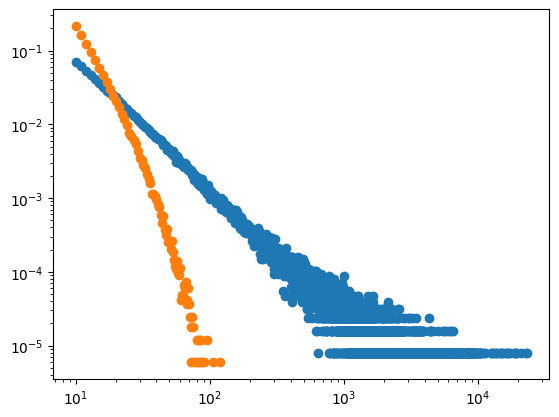

In [36]:
area = df['area'].values
area = area[df['density'].between(0.2, 0.4)]
unique, counts = np.unique(area, return_counts=True)

counts = counts / counts.sum()

area_gen = df_gen['area'].values
area_gen = area_gen[df_gen['density'].between(0.2, 0.4)]
unique_gen, counts_gen = np.unique(area_gen, return_counts=True)
counts_gen = counts_gen / counts_gen.sum()

x = np.geomspace(10, 1000, 100)
plt.figure()
plt.scatter(unique, counts)
plt.scatter(unique_gen, counts_gen)
# plt.plot(x, np.power(x, -1.))
plt.yscale('log')
plt.xscale('log')
plt.show()

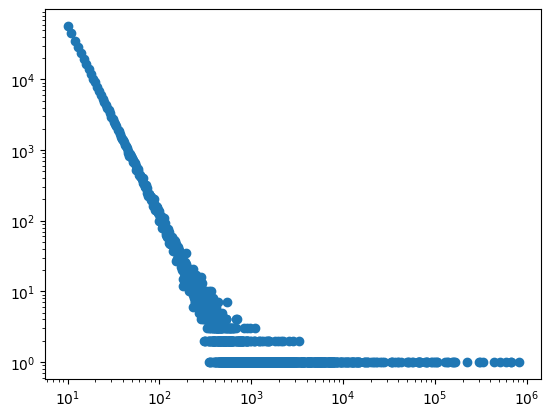

In [10]:
area = df_gen['area'].values
unique, counts = np.unique(area, return_counts=True)

plt.figure()
plt.scatter(unique, counts)
plt.yscale('log')
plt.xscale('log')
plt.show()

### Elongation

-----------------------------------------
E10691_RBM20 :  SUB-ENDO
-----------------------------------------
count    60526.000000
mean         2.634954
std          1.426494
min          1.000000
25%          1.696621
50%          2.262687
75%          3.144985
max         40.349456
Name: axis_ratio, dtype: float64
-----------------------------------------
(0.7096680213770257, 0.8321161025784402, 1.4072469712732856)
mean: 2.642
std: 1.465
median: 2.239
-----------------------------------------
E10691_RBM20 :  SUB-ENDO
-----------------------------------------
count    43570.000000
mean         2.112158
std          0.771084
min          1.000000
25%          1.545987
50%          1.943963
75%          2.496619
max         10.148495
Name: axis_ratio, dtype: float64
-----------------------------------------
(0.55318463531754, 0.7497786210963646, 1.1732858303334799)
mean: 2.117
std: 0.818
median: 1.923
-----------------------------------------
E10691_RBM20 :  MID
------------------------

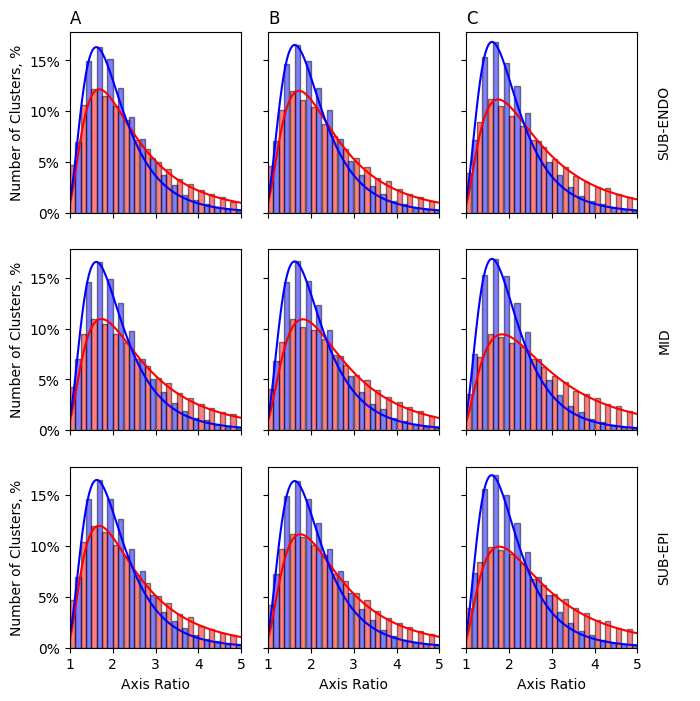

In [39]:
def degrees_formatter(x, pos):
    return f"{int(x)}°"


def percent_formatter(x, pos):
    return f"{int(x * 100)}%"


bins = np.linspace(-90, 90, 19)
colors_ = ['red', 'blue']

ddf = df[df['density'].between(0, 0.4)]
ddf_gen = df_gen[df_gen['density'].between(0, 0.4)]

grouped = df.groupby(['heart', 'location'], observed=True)
grouped_gen = df_gen.groupby(['heart', 'location'], observed=True)

bins = np.linspace(1, 5, 17)

fig, axs = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True,
                        gridspec_kw={'width_ratios': [1, 1, 1, 0.15]},
                        figsize=(8, 8))

for i, (heart, label) in enumerate(hearts.items()):
    for j, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):
        for k, gr in enumerate([grouped, grouped_gen]):
            data = gr.get_group((heart, location))
            count, _ = np.histogram(data['axis_ratio'].values, bins=bins)

            count = count / len(data['axis_ratio'].values)
            params = stats.lognorm.fit(data['axis_ratio'].values)

            x = np.linspace(1, 5, 100)
            lognorm_y = stats.lognorm.pdf(x, *params)
            # lognorm_y = lognorm_y / stats.lognorm.pdf([bins[max_id + 1]], *params) * count.max()
            lognorm_y = count.max() * lognorm_y / lognorm_y.max()
            print('-----------------------------------------')
            print(heart, ': ', location)
            print('-----------------------------------------')
            print(data['axis_ratio'].describe())
            print('-----------------------------------------')
            print(params)
            print(f'mean: {stats.lognorm.mean(*params):.3f}')
            print(f'std: {stats.lognorm.std(*params):.3f}')
            print(f'median: {stats.lognorm.median(*params):.3f}')

            axs[j, i].plot(x, lognorm_y, color=colors_[k])

            axs[j, i].bar(bins[:-1] + k * 0.125, count, width=0.12, align='edge',
                          color=colors_[k], edgecolor='black', alpha=0.5)
        axs[j, i].set_xlim(1, 5)
        axs[j, i].yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))

for j, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):
    axs[j, 0].set_ylabel('Number of Clusters, %')
    axs[j, -1].set_axis_off()
    axs[j, -1].text(0., 0.5, location, transform=axs[j, -1].transAxes,
                    ha='center', va='center', rotation=90)

for i, (_, label) in enumerate(hearts.items()):
    axs[0, i].set_title(label, loc='left')
    axs[2, i].set_xlabel('Axis Ratio')

plt.show()

In [50]:
2.642 - 0.71**2

2.1379